
# Homework 1: Eigenflowers (PCA on Images)

This notebook walks through an **end-to-end PCA pipeline** on a non-face image dataset (e.g., **Oxford 102 Flowers**).  
You will:
- Preprocess images (grayscale, resize, flatten)
- Build the data matrix `A` (pixels × samples)
- Compute PCA via **dual trick** (`L = AᵀA / M`) **or** via **thin SVD**
- Visualize the **mean image** and **top eigenimages** ("eigenflowers")
- Reconstruct images using the top-k components and evaluate error

> **For homework 1:** This notebook is commented and includes **TODO** markers.  
> Please add your implementation where the **TODO** markers are, including code and Markdown cells.



## 0) Environment & Imports

We will use the standard scientific Python packages (`numpy`, `PIL`, `matplotlib`) along with `hashlib`.   
Note that each student should have their own unique seed for repeatability.   
Make sure your kernel uses Python ≥ 3.8.


In [24]:
# Imports
import os
import numpy as np
import hashlib
from PIL import Image
import matplotlib.pyplot as plt

# Set a fixed random seed (given for each student) for reproducibility
# **TODO** set your own fixed token with the ***last 4 digits of your UB person number***
# Reproducibility via TOKEN
TOKEN = "1896"  # unique token per student
SEED = int(hashlib.sha256(TOKEN.encode()).hexdigest(), 16) % (10**6)
print("SEED:", SEED)

# Matplotlib defaults (no specific colors)
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["axes.grid"] = True


SEED: 27041



## 1) Point to your dataset

- Download and extract **Flowers dataset** (from the given image folder) locally.
- Set `DATA_DIR` to the folder containing the training images.
- Choose a target size (e.g., **64×64**) and an optional cap on images for quick experiments.


In [25]:

# === YOUR INPUTS ===
DATA_DIR = "dataset/train"   # <-- TODO: set this to your local training data path
OUTPUT_SIZE = (64, 64)         # TODO: you can try (32, 32) for speed
MAX_IMAGES = 10               # TODO: set an int (e.g., 10) to cap for quick tests



## 2) Preprocessing helpers

We have small utilities for you to:
- Walk the dataset directory
- Convert to **grayscale**
- **Resize** to the same size
- **Flatten** to vectors and **normalize** to `[0,1]`
- Stack as columns into the data matrix **A** of shape `(pixels, M)`


In [26]:

def load_and_preprocess(data_dir, size=(64, 64), max_images=None):
    '''
    Load images recursively from 'data_dir'.
    Convert to grayscale, resize to 'size', flatten, normalize to [0,1].
    Returns:
      A: np.ndarray shape (pixels, M)  -- data matrix (columns are images)
      paths: list[str]                 -- list of file paths used (length M)
    '''
    vectors = []
    paths = []
    for root, _, files in os.walk(data_dir):
        for fn in files:
            if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                path = os.path.join(root, fn)
                try:
                    img = Image.open(path).convert('L').resize(size)  # grayscale + resize
                    vec = np.asarray(img, dtype=np.float32).flatten() / 255.0
                    vectors.append(vec)
                    paths.append(path)
                    if max_images is not None and len(vectors) >= max_images:
                        break
                except Exception as e:
                    print(f"[warn] Skipping {path}: {e}")
        if max_images is not None and len(vectors) >= max_images:
            break

    if not vectors:
        raise RuntimeError("No images found. Check your DATA_DIR and file extensions.")

    A = np.column_stack(vectors)  # shape: (pixels, M)
    return A, paths

# Quick test on function signature (no execution yet).
print("Helper 'load_and_preprocess' defined.")


Helper 'load_and_preprocess' defined.



## 3) Load & preprocess images

You may want to use only a small number of images and make them small (32x32) while coding and debugging


In [27]:

# TODO: Uncomment to run when DATA_DIR is set correctly.
A, paths = load_and_preprocess(DATA_DIR, size=OUTPUT_SIZE, max_images=MAX_IMAGES)
print("A.shape (pixels x M):", A.shape)
print("Example paths (first 3):", paths[:3])


A.shape (pixels x M): (4096, 10)
Example paths (first 3): ['dataset/train/image_05106.jpg', 'dataset/train/image_05113.jpg', 'dataset/train/image_07089.jpg']



## 4) TODO: Mean image & centering

PCA expects **mean-centered** data.  
- Compute the **mean image** across columns of `A`  
- Subtract it from each column to get `A_centered`


mean_image shape: (4096, 1)
A_centered shape: (4096, 10)
||A_centered column means|| (first 5 dims): [ 0. -0. -0. -0. -0.]


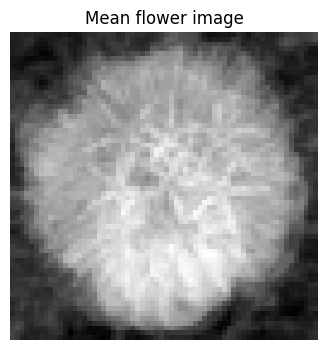

In [28]:

# TODO: Compute the mean image and obtain `A_centered` from the `A` built in the cell above
# Then plot your mean image to ensure it looks like a flower... somewhat...


mean_image = A.mean(axis=1, keepdims=True)   
A_centered = A - mean_image                 

print("mean_image shape:", mean_image.shape)       
print("A_centered shape:", A_centered.shape)       
print("||A_centered column means|| (first 5 dims):",
      np.round(np.mean(A_centered, axis=1)[:5], 6))

# visualize the mean image
plt.imshow(mean_image.reshape(OUTPUT_SIZE[1], OUTPUT_SIZE[0]), cmap="gray")
plt.title("Mean flower image")
plt.axis("off")
plt.show()


## 5) TODO: Implement PCA (Method 1): Thin SVD

Compute SVD of `A_centered` directly: 
You can use the `SVD` function from the `linalg` library in numpy
> $A_{\text{centered}} = U \Sigma V^\top$

- Covariance eigenvalues: $\lambda_i = \frac{1}{M}\sigma_i^2$  
- Eigenimages (eigenvectors) are the columns of $U$

> **This metod is often numerically preferred as it is more stable**

In [29]:

def pca_svd(A_centered, num_components=None):
    '''
    PCA via thin SVD.
    Returns:
      U_k: eigenimages (pixels x k), orthonormal columns
      eigvals_k: covariance eigenvalues (length k), sorted desc
    '''
    # Thin SVD: A_c = U Σ V^T
    U, S, Vt = np.linalg.svd(A_centered, full_matrices=False)
    
    # Covariance eigenvalues: λ_i = (1/M) * σ_i^2
    M = A_centered.shape[1]
    eigvals = (S**2) / M
    
    # Keep top-k if requested
    if num_components is not None:
        U = U[:, :num_components]
        eigvals = eigvals[:num_components]
    
    return U, eigvals

print("Helper 'pca_svd' defined.")


Helper 'pca_svd' defined.


In [30]:
U1, eigvals1 = pca_svd(A_centered, num_components=None)
print("U1.shape:", U1.shape)                 # (pixels, M) for full run
print("eigvals1.shape:", eigvals1.shape)     # (M,)
print("eigvals1 nonneg? min=", eigvals1.min())
print("orthonormal? ||U^T U - I||_F =", np.linalg.norm(U1.T @ U1 - np.eye(U1.shape[1])))

U1.shape: (4096, 10)
eigvals1.shape: (10,)
eigvals1 nonneg? min= 2.8326952e-12
orthonormal? ||U^T U - I||_F = 2.6017831599208874e-07



## 6) TODO: PCA (Method 2a): Dual trick

Compute eigenpairs of the small **sample–sample** $L$ matrix given $A_{\text{centered}}$:

$L = \frac{1}{M} A^\top A \in \mathcal{R}^{M \times M}$,

- Solve $L v_i = \lambda_i v_i$; You can use the prebuilt linear algebra $\texttt{eigvals, V = np.linalg.eigh}$ function call
- This will return the eigen values and vectors in $\textbf{ascending}$ order; you want to reverse this order
- Now map this back into the feature space: $u_i = A_{\text{centered}}\; v_i$
- Normalize each $u_i$ to unit length

In [31]:

def pca_dual(A_centered, num_components=None):
    '''
    PCA via dual trick: eigendecompose L = (A^T A)/M, then map back to feature space.
    Returns:
      U: eigenimages as columns (pixels x k), unit-norm
      eigvals: covariance eigenvalues (length k), sorted desc
    '''
    # 1) small sample–sample matrix
    M = A_centered.shape[1]
    L = (A_centered.T @ A_centered) / M            # (M x M), symmetric

    # 2) eigendecompose (ascending), then reverse to descending
    eigvals, V = np.linalg.eigh(L)                  # eigvals asc
    idx = np.argsort(eigvals)[::-1]                 # to desc
    eigvals = eigvals[idx]
    V = V[:, idx]

    # 3) keep top-k if requested
    if num_components is not None:
        V = V[:, :num_components]
        eigvals = eigvals[:num_components]

    # 4) map back to pixel space and normalize each eigenimage
    U = A_centered @ V                              # (pixels x k)
    U /= (np.linalg.norm(U, axis=0, keepdims=True) + 1e-12)

    return U, eigvals

print("Helper 'pca_dual' defined.")


Helper 'pca_dual' defined.


In [32]:
U2, eigvals2 = pca_dual(A_centered, num_components=None)
print("U2.shape:", U2.shape)
print("eigvals2.shape:", eigvals2.shape)

# Compare with SVD results (should be very close, up to tiny diffs/sign flips)
print("eigvals close? ", np.allclose(eigvals2, eigvals1, rtol=1e-4, atol=1e-7))

# Cosine similarity of first few eigenimages (abs due to sign ambiguity)
k_check = min(10, U1.shape[1], U2.shape[1])
cos = np.abs(np.sum(U1[:, :k_check] * U2[:, :k_check], axis=0))
print("cosine similarity (first k):", np.round(cos, 4))

U2.shape: (4096, 10)
eigvals2.shape: (10,)
eigvals close?  False
cosine similarity (first k): [1.     1.     1.     1.     1.     1.     1.     1.     1.     0.5435]


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2107306886.py:24: RuntimeWarning: divide by zero encountered in matmul
  U = A_centered @ V                              # (pixels x k)
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2107306886.py:24: RuntimeWarning: overflow encountered in matmul
  U = A_centered @ V                              # (pixels x k)
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2107306886.py:24: RuntimeWarning: invalid value encountered in matmul
  U = A_centered @ V                              # (pixels x k)


## 7) TODO: PCA (Method 2b): Dual trick + Eigendecomposition using the Power Method

Again we want to compute eigenpairs of the $L$ matrix, but this time we will use the **power method**:

- We again want to solve $L v_i = \lambda_i v_i$
- We will implement our own version of the power method
>   We will write 2 auxilliary functions to aid with this
- Like before, the power method will return the eigen values and vectors, but in descending order
- Now map this back into the feature space: $u_i = A_{\text{centered}}\; v_i$
- Normalize each $u_i$ to unit length

### Aux 1) TODO: The Power Method for the most dominant eigenpair (single)   
$\textbf{GOAL:}$ Approximate the dominant eigenvalue $\lambda_{\max}$ and corresponding eigenvector $v_{\max}$ of a matrix $L \in \mathbb{R}^{m \times m}$.

PSEUDOCODE FOR POWER METHOD:
1. Create a random vector $x_0$ of length $\texttt{L.shape[0]}$  
   - Normalize the vector via $\frac{x_0}{\|x_0\|}$  
   - Set $\lambda_0 = 0.0$ <br>

2. For $k = 1, 2, \dots, \texttt{num\_iter}$
    - Multiply: $y_k = L x_{k-1}$ 
    - Normalize: $x_k = \tfrac{y_k}{\|y_k\|}$
    - Rayleigh quotient: $\lambda_k = x_k^\top L x_k$
    - if $|\lambda_k - \lambda_{k-1}| \le \epsilon$; BREAK   

3. Output $(\lambda_k, x_k)$ as approximation of the dominant eigenpair.

$\textbf{Note:}$ these are all matrix multiplications - use the operator "@"


In [ ]:
def power_method_sym(L, num_iters=200, tol=1e-12, x0=None):
   '''
    power_method_sym takes a symmetrical matrix L, the number of iterations and a tolerance value
    Returns:
      lam: the most domainant eigenvalue of L
      x: the correspondng eigenvector
    '''
    #TODO - enter your code here...    
    
    return lam, x

### Aux 2) TODO: The Power Method to compute the top-k eigenpairs of L (symmetrical)

$k = \min(k, m)$; where $m$ is $\texttt{L.shape[0]}$  

For $i = 1, 2, \dots, k$   
   - call $\lambda_k, v_k =$ power_method_sym$(L)$
   - next perform a $\textbf{rank-1 deflation}$ of $L$:
      - set $L \leftarrow L - \lambda_k v_k v_k^\top$
      - repeat the power method on deflations of $L$ to get the remaining eigenpairs in a descending order of $\lambda$'s


In [ ]:
def power_method_sym_allk(L, k=None, num_iters=200, tol=1e-8, sort_by_abs=True):
    """
    Compute the top-k eigenpairs of a symmetric matrix L using power iteration with deflation.
    """
    #TODO - enter your code here...
    
    return lambdas, V

### TODO: Now implement pca_dualpower 

Use the the same signature as the other PCA calls; use your auxilliary methods and have the same return values

In [ ]:
def pca_dualpower(A_centered, num_components=None):
    '''
    PCA via dual trick: using your own handwritten Power Method
    Returns:
      U: eigenimages as columns (pixels x k), unit-norm
      eigvals: covariance eigenvalues (length k), sorted desc
    '''
    #TODO - enter your code here...
      
    return U, eigvals

print("Helper 'pca_dualpower' defined.")

### 8) TODO: Compute your eigenflowers using each of the 3 PCA methods (1:thin SVD, 2:dual method, 3:dual with power method)


In [ ]:

# TODO: Uncomment and run after you have defined the processes above
#U1, eigvals1 = pca_svd(A_centered, num_components=None)
# print("U1.shape (pixels x k):", U1.shape)
# print("eigvals1.shape:", eigvals1.shape)

#U2, eigvals2 = pca_dual(A_centered, num_components=None)
#print("U2.shape (pixels x k):", U2.shape)
#print("eigvals2.shape:", eigvals2.shape)

#U3, eigvals3 = pca_dualpower(A_centered, num_components=None)
#print("U3.shape (pixels x k):", U3.shape)
#print("eigvals3.shape:", eigvals3.shape)



## 9) Visualize the top eigenflowers


In [ ]:

def show_eigenimages(U, size, k=6, title_prefix="Eigenimage"):
    k = min(k, U.shape[1])
    if k <= 0:
        print("[warn] No eigenimages to display.")
        return
    fig, axes = plt.subplots(1, k, figsize=(2.2*k, 2.8))
    if k == 1:
        axes = [axes]
    for i in range(k):
        axes[i].imshow(U[:, i].reshape(size[::-1]), cmap="gray")
        axes[i].set_title(f"{title_prefix} {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Run after U1, U2, U3 are available
show_eigenimages(U3, OUTPUT_SIZE, k=6, title_prefix="Eigenflower")


## 10) TODO: Reconstruction with top-k components

Pick one image, project onto top-k eigenimages, and reconstruct.  
Display your reconstructions  
Observe how reconstruction improves as k increases.


In [ ]:

def reconstruct_with_k(U, mean_image, x_centered, k):
    '''
        reconstruct_with_k should return a vector of the reconstructed input x_centered
    '''
    #TODO - enter your code here...
    
    return recon_x

#choose an image index and k (components) list
j = 11
ks = [5, 10, 15, 20, 25, 30]



#Load the test images
B, _ = load_and_preprocess(TEST_DIR, size=OUTPUT_SIZE, max_images=MAX_IMAGES)
B_centered = B - mean_image[:, None] # remeber the mean image must be from A

# TODO: Uncomment and run on a training image in A, after it is centered; A_centered, U, and mean_image exist
#orig = A[:, j]
#x = A_centered[:, j]
#then run on the test data
#orig = B[:, j]
#x = B_centered[:, j]
# 

recons_x = []
mses = []
for k in ks:
    r = reconstruct_with_k(U3, mean_image, x, k)
    recons_x.append(r)
    mses.append(float(np.mean((orig - r)**2)))

# # Plot original + reconstructions
cols = len(ks) + 1
plt.figure(figsize=(2.2*cols, 2.8))
ax = plt.subplot(1, cols, 1)
ax.imshow(orig.reshape(OUTPUT_SIZE[::-1]), cmap="gray")
ax.set_title("Original")
ax.axis("off")
for i, (k, r, mse) in enumerate(zip(ks, recons_x, mses), start=2):
    ax = plt.subplot(1, cols, i)
    ax.imshow(r.reshape(OUTPUT_SIZE[::-1]), cmap="gray")
    ax.set_title(f"k={k}\nMSE={mse:.4f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# # Error curve
plt.figure(figsize=(5,3))
plt.plot(ks, mses, marker="o")
plt.xlabel("Number of components (k)")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction error vs k")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




## 11) TODO: Explained variance; plot the cummulative explained variance   

Plot how much variation is captured by the first k components.   

$EVR_k = \frac{\lambda_k}{\sum_{i=1}^p \lambda_i}$

Cummulative $EVR_m = \frac{\sum_{k=1}^m \lambda_k}{\sum_{i=1}^p \lambda_i}$

Plot $EVR_m$ at every $m$


In [ ]:
#####
#TODO - enter your code here to solve for cummu, the cummlative EVR

#plot cummu
plt.figure(figsize=(6,3.5))
plt.plot(np.arange(1, len(cummu)+1), cummu, marker='o')
plt.xlabel("Number of components (k)")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs components")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 12) TODO: Feature Mapping
- Explain how this approach can be used for feature extraction - you can explain that here...

- What exactly are the features and how do we obtain them here?